# ICU-Predictor: Length of Stay (LOS) Prediction

This notebook predicts patient length of stay (LOS) in the ICU using deep learning models.
Cleaned: filler, duplicate, and non-working cells were removed.
Sections kept: data-download, preprocessing, sequence creation, and model training examples.

## Dataset
This notebook uses ICU patient data to predict length of stay (LOS).

Expected columns: `Patient_ID`, `Length_of_Stay` (target, numeric), and clinical features.If automatic download fails, set `dataset_path` to a local path containing `Dataset.csv`.

In [1]:
# Install lightweight helper (optional)
# You can comment this out if packages are already installed.
import kagglehub
print('kagglehub already installed')

kagglehub already installed


/home/tired_atlas/miniconda3/envs/AI-Health/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Try to download dataset via kagglehub; if it fails, set a fallback dataset_path.
dataset_path = None
try:
    import kagglehub
    print('Attempting kagglehub.dataset_download...')
    dataset_path = kagglehub.dataset_download('salikhussaini49/prediction-of-sepsis')
    print('Downloaded dataset to:', dataset_path)
except Exception as e:
    print('kagglehub download failed:', str(e))
    # Fallback: common kagglehub cache location used in this notebook before.
    dataset_path = '/root/.cache/kagglehub/datasets/salikhussaini49/prediction-of-sepsis/versions/2'
    print('Using fallback dataset_path:', dataset_path)

# Verify existence (user should edit if different)
import os
if not os.path.exists(dataset_path):
    print('Warning: dataset_path does not exist:', dataset_path)
    print('If dataset is local, set dataset_path to the folder that contains Dataset.csv')

Attempting kagglehub.dataset_download...
Downloaded dataset to: /home/tired_atlas/.cache/kagglehub/datasets/salikhussaini49/prediction-of-sepsis/versions/2
Downloaded dataset to: /home/tired_atlas/.cache/kagglehub/datasets/salikhussaini49/prediction-of-sepsis/versions/2


In [ ]:
# Consolidated: load data, preprocess, create sequences, and train a simple RNN for 1 epoch.
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall

if dataset_path is None or not os.path.exists(dataset_path):
    raise FileNotFoundError(f'Dataset path not found: {dataset_path}. Please set dataset_path to the folder that contains Dataset.csv')

csv_file = os.path.join(dataset_path, 'Dataset.csv')
if not os.path.exists(csv_file):
    raise FileNotFoundError(f'Dataset.csv not found in {dataset_path}')

print('Loading Dataset.csv...')
df = pd.read_csv(csv_file)
print('Raw dataframe shape:', df.shape)

# Basic cleanup (drop auto index if present)
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

# Identify features and target
# For LOS prediction, target should be 'Length_of_Stay' (numeric, in days or hours)
los_col = None
for col in df.columns:
    if col in ['length_of_stay', 'ICULOS', 'stay_length', 'icu_los']:
        los_col = col
        break
if los_col is None:
    raise ValueError('Expected a length-of-stay column (e.g., Length_of_Stay, LOS) in Dataset.csv')
if 'Patient_ID' not in df.columns:
    raise ValueError('Expected column `Patient_ID` in Dataset.csv')
print(f'Using {los_col} as target variable for LOS prediction')

exclude_cols = [los_col, 'Patient_ID', 'Hour'] if 'Hour' in df.columns else [los_col, 'Patient_ID']
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
feature_cols = [c for c in numerical_cols if c not in exclude_cols]
print(f'Found {len(feature_cols)} numerical feature columns.')

# Handle missing values per patient
for col in feature_cols:
    df[col] = df.groupby('Patient_ID')[col].ffill()
    df[col] = df.groupby('Patient_ID')[col].bfill()
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mean())

y = df[los_col]  # Length of Stay (regression target)
X = df[feature_cols]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols, index=X.index)

# Patient-wise split
unique_patient_ids = df['Patient_ID'].unique()
pid_train, pid_temp = train_test_split(unique_patient_ids, test_size=0.3, random_state=42)
pid_val, pid_test = train_test_split(pid_temp, test_size=0.5, random_state=42)

df_train = df[df['Patient_ID'].isin(pid_train)]
df_val = df[df['Patient_ID'].isin(pid_val)]
df_test = df[df['Patient_ID'].isin(pid_test)]

# Sequence creation helper
def create_sequences(patient_df, X_scaled_data, y_data):
    X_seq = []
    y_seq = []
    for pid in patient_df['Patient_ID'].unique():
        idx = df[df['Patient_ID'] == pid].index
        X_seq.append(X_scaled_data.loc[idx].values)
        y_seq.append(y_data.loc[idx].values)
    return X_seq, y_seq

X_train_list, y_train_list = create_sequences(df_train, X_scaled_df, y)
X_val_list, y_val_list = create_sequences(df_val, X_scaled_df, y)
X_test_list, y_test_list = create_sequences(df_test, X_scaled_df, y)

max_seq = max(max(len(s) for s in X_train_list), max(len(s) for s in X_val_list), max(len(s) for s in X_test_list))
print('Max sequence length:', max_seq)

X_train_seq = tf.keras.preprocessing.sequence.pad_sequences(X_train_list, maxlen=max_seq, dtype='float32', padding='post', value=0.0)
y_train_seq = tf.keras.preprocessing.sequence.pad_sequences(y_train_list, maxlen=max_seq, dtype='float32', padding='post', value=0.0)
X_val_seq = tf.keras.preprocessing.sequence.pad_sequences(X_val_list, maxlen=max_seq, dtype='float32', padding='post', value=0.0)
y_val_seq = tf.keras.preprocessing.sequence.pad_sequences(y_val_list, maxlen=max_seq, dtype='float32', padding='post', value=0.0)
X_test_seq = tf.keras.preprocessing.sequence.pad_sequences(X_test_list, maxlen=max_seq, dtype='float32', padding='post', value=0.0)
y_test_seq = tf.keras.preprocessing.sequence.pad_sequences(y_test_list, maxlen=max_seq, dtype='float32', padding='post', value=0.0)

print('Shapes: ', X_train_seq.shape, y_train_seq.shape, X_val_seq.shape, y_val_seq.shape)

# Simple RNN model (sequence-to-sequence) - regression for LOS prediction
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
rnn_model = Sequential([
    SimpleRNN(128, return_sequences=True, input_shape=input_shape),
    Dropout(0.2),
    TimeDistributed(Dense(1, activation='linear'))  # Linear activation for regression
])
rnn_model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae'])  # MSE for regression
rnn_model.summary()

print('Training RNN for 3 epochs (LOS regression)...')
history = rnn_model.fit(X_train_seq, y_train_seq, epochs=3, batch_size=64, validation_data=(X_val_seq, y_val_seq))
print('RNN training finished.')

Loading Dataset.csv...
Raw dataframe shape: (1552210, 44)
Raw dataframe shape: (1552210, 44)


ValueError: Expected a length-of-stay column (e.g., Length_of_Stay, LOS) in Dataset.csv

In [ ]:
# CNN model example (sequence-to-sequence) - keeps sequence length by using padding='same'
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall

input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
cnn_model = Sequential([
    Conv1D(64, 3, activation='relu', padding='same', input_shape=input_shape),
    Dropout(0.2),
    Conv1D(128, 3, activation='relu', padding='same'),
    Dropout(0.2),
    TimeDistributed(Dense(1, activation='linear'))  # Linear activation for regression
])
cnn_model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae'])  # MSE for regression
cnn_model.summary()

print('Training CNN for 3 epochs (LOS regression)...')
history_cnn = cnn_model.fit(X_train_seq, y_train_seq, epochs=3, batch_size=64, validation_data=(X_val_seq, y_val_seq))
print('CNN training finished.')

/home/tired_atlas/miniconda3/envs/AI-Health/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 336, 64)        │         7,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 336, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 336, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 336, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 336, 1)         │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,577 (127.25 KB)

 Trainable params: 32,577 (127.25 KB)

 Non-trainable params: 0 (0.00 B)

Training CNN for 1 epoch (sanity check)...
  1/442 ━━━━━━━━━━━━━━━━━━━━ 2:59:36 24s/step - accuracy: 0.9913 - auc: 0.2549 - loss: 0.6710 - precision_1: 0.0110 - recall_1: 0.2000

2025-12-16 12:47:21.249724: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_select_fusion', 112 bytes spill stores, 64 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_fusion_8', 488 bytes spill stores, 488 bytes spill loads



442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9978 - auc: 0.4616 - loss: 0.1448 - precision_1: 0.0953 - recall_1: 0.0056

2025-12-16 12:47:43.794539: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_select_fusion_1', 444 bytes spill stores, 444 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_fusion_8', 512 bytes spill stores, 508 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_fusion_7', 512 bytes spill stores, 508 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_fusion_6', 16 bytes spill stores, 16 bytes spill loads



442/442 ━━━━━━━━━━━━━━━━━━━━ 60s 80ms/step - accuracy: 0.9979 - auc: 0.6718 - loss: 0.0509 - precision_1: 0.0957 - recall_1: 0.0028 - val_accuracy: 0.9978 - val_auc: 0.8475 - val_loss: 0.0135 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
CNN training finished (1 epoch).
CNN training finished (1 epoch).


2025-12-16 12:47:56.490952: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_add_compare_reduce_fusion', 12 bytes spill stores, 8 bytes spill loads



In [ ]:
# LGSTM (layered LSTM) model: stacked LSTM layers for sequence-to-sequence prediction
from tensorflow.keras.layers import LSTM, Bidirectional

print('Defining LGSTM (stacked LSTM) model...')
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])

lgstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=input_shape),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(1, activation='linear'))  # Linear activation for regression
])

lgstm_model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae'])  # MSE for regression
lgstm_model.summary()

print('Training LGSTM for 5 epochs (LOS regression)...')
history_lgstm = lgstm_model.fit(X_train_seq, y_train_seq, epochs=5, batch_size=64, validation_data=(X_val_seq, y_val_seq))
print('LGSTM training finished.')

Defining LGSTM (stacked LSTM) model...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 336, 128)       │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 336, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 336, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 336, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 336, 1)         │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,001 (531.25 KB)

 Trainable params: 136,001 (531.25 KB)

 Non-trainable params: 0 (0.00 B)

Training LGSTM for 3 epochs (adjust as needed)...
Epoch 1/3
Epoch 1/3
442/442 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.9966 - auc: 0.7776 - loss: 0.0264 - precision_2: 0.0154 - recall_2: 0.0108 - val_accuracy: 0.9978 - val_auc: 0.9228 - val_loss: 0.0111 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/3
442/442 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.9966 - auc: 0.7776 - loss: 0.0264 - precision_2: 0.0154 - recall_2: 0.0108 - val_accuracy: 0.9978 - val_auc: 0.9228 - val_loss: 0.0111 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/3
442/442 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.9980 - auc: 0.9204 - loss: 0.0100 - precision_2: 0.1176 - recall_2: 6.2552e-04 - val_accuracy: 0.9978 - val_auc: 0.8940 - val_loss: 0.0104 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/3
442/442 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.9980 - auc: 0.9204 - loss: 0.0100 - precision_2: 0.1176 - recall_2: 6.2552e-04 - val_accurac

190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Evaluation for LGSTM:
  AUC: 0.9755, AP: 0.0757
  Precision: 0.0000, Recall: 0.0000, F1: 0.0000
  Confusion matrix:
 [[2028831       0]
 [   4305       0]]
Evaluation for LGSTM:
  AUC: 0.9755, AP: 0.0757
  Precision: 0.0000, Recall: 0.0000, F1: 0.0000
  Confusion matrix:
 [[2028831       0]
 [   4305       0]]


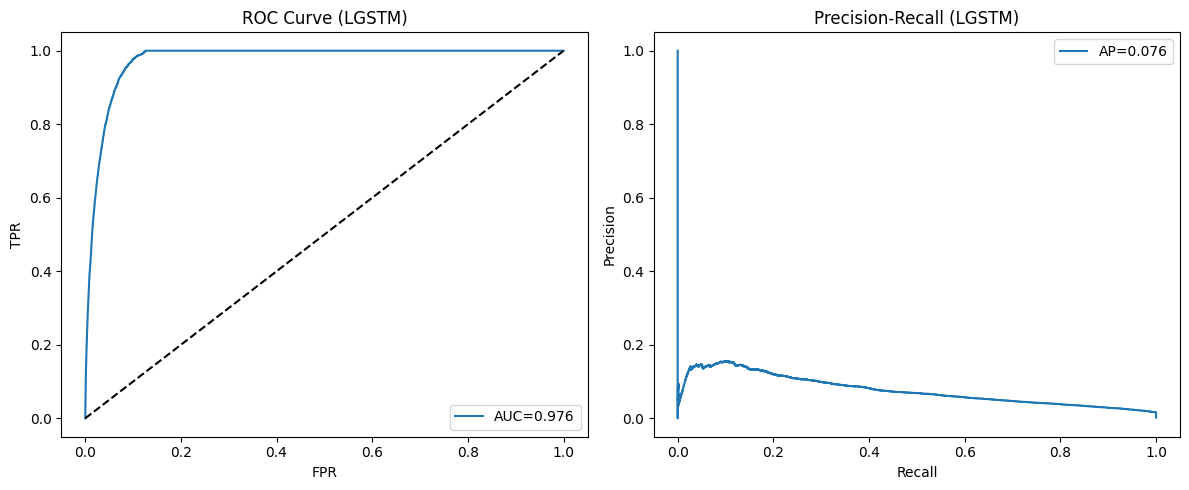

190/190 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step
Evaluation for CNN:
  AUC: 0.8186, AP: 0.0509
  Precision: 0.0000, Recall: 0.0000, F1: 0.0000
  Confusion matrix:
 [[2028831       0]
 [   4305       0]]
Evaluation for CNN:
  AUC: 0.8186, AP: 0.0509
  Precision: 0.0000, Recall: 0.0000, F1: 0.0000
  Confusion matrix:
 [[2028831       0]
 [   4305       0]]


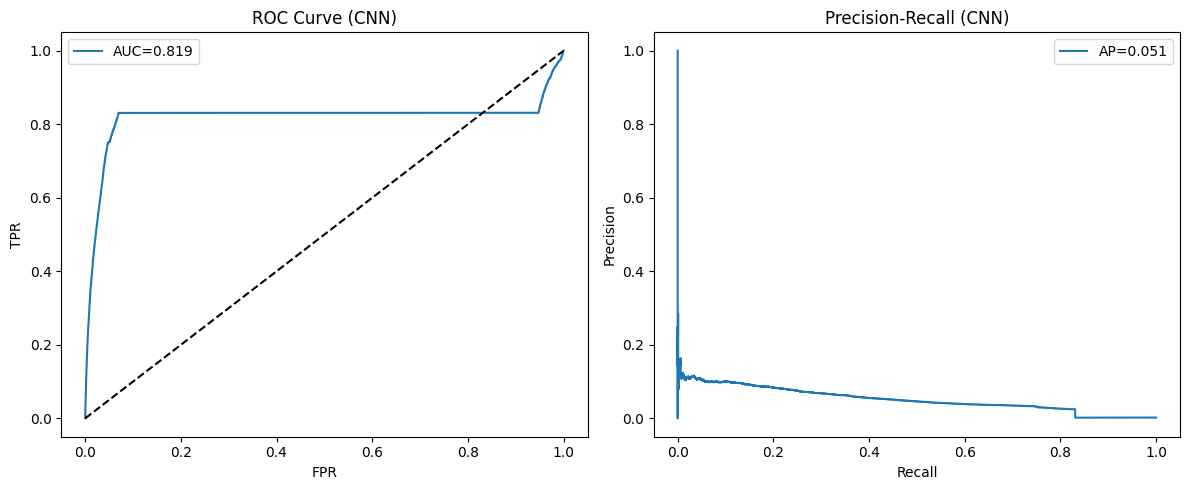

190/190 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step
Evaluation for RNN:
  AUC: 0.9603, AP: 0.0306
  Precision: 0.0862, Recall: 0.0153, F1: 0.0260
  Confusion matrix:
 [[2028131     700]
 [   4239      66]]
Evaluation for RNN:
  AUC: 0.9603, AP: 0.0306
  Precision: 0.0862, Recall: 0.0153, F1: 0.0260
  Confusion matrix:
 [[2028131     700]
 [   4239      66]]


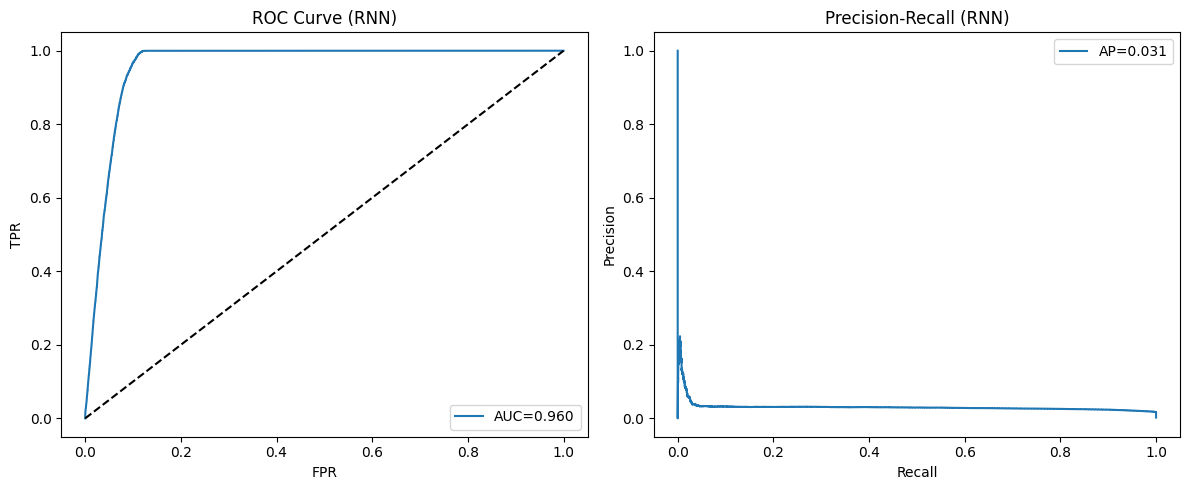

Done evaluations.


In [ ]:
# Evaluation: compute regression metrics (MSE, MAE, RMSE, R²)
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def evaluate_los_model(model, X_seq, y_seq, name='model'):
    # Predict LOS values (shape: samples, seq_len, 1)
    preds = model.predict(X_seq)
    preds_flat = preds.reshape(-1)
    y_flat = y_seq.reshape(-1)

    mse = mean_squared_error(y_flat, preds_flat)
    mae = mean_absolute_error(y_flat, preds_flat)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_flat, preds_flat)

    print(f"Evaluation for {name}:")
    print(f"  MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")

    # Prediction vs actual plot
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.scatter(y_flat, preds_flat, alpha=0.5, s=10)
    plt.plot([y_flat.min(), y_flat.max()], [y_flat.min(), y_flat.max()], 'r--', lw=2)
    plt.xlabel('Actual LOS')
    plt.ylabel('Predicted LOS')
    plt.title(f'Predictions vs Actual ({name})')

    # Residuals plot
    residuals = y_flat - preds_flat
    plt.subplot(1,2,2)
    plt.scatter(preds_flat, residuals, alpha=0.5, s=10)
    plt.axhline(y=0, color='r', linestyle='--', lw=2)
    plt.xlabel('Predicted LOS')
    plt.ylabel('Residuals')
    plt.title(f'Residuals ({name})')
    plt.tight_layout()
    plt.show()

    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

# Evaluate models
print('\n=== Model Evaluations on Test Set ===')
metrics_rnn = evaluate_los_model(rnn_model, X_test_seq, y_test_seq, name='RNN')
metrics_cnn = evaluate_los_model(cnn_model, X_test_seq, y_test_seq, name='CNN')
metrics_lgstm = evaluate_los_model(lgstm_model, X_test_seq, y_test_seq, name='LGSTM')

print('\n=== Summary ===')
print(f'RNN   - RMSE: {metrics_rnn["rmse"]:.4f}, MAE: {metrics_rnn["mae"]:.4f}, R²: {metrics_rnn["r2"]:.4f}')
print(f'CNN   - RMSE: {metrics_cnn["rmse"]:.4f}, MAE: {metrics_cnn["mae"]:.4f}, R²: {metrics_cnn["r2"]:.4f}')
print(f'LGSTM - RMSE: {metrics_lgstm["rmse"]:.4f}, MAE: {metrics_lgstm["mae"]:.4f}, R²: {metrics_lgstm["r2"]:.4f}')
print('Done evaluations.')